In [1]:
DEBUG = False
DISABLE_GPU = False
USE_CONTROL_SET = True

COLLECTION_NAME = 'documents'



In [2]:
if USE_CONTROL_SET:
    COLLECTION_NAME = 'documents_temp'

In [3]:
import logging
import sys
import os

In [4]:


# DISABLE GPU
if DISABLE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'




In [5]:



logger = logging.getLogger('eval_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - [%(filename)s:%(lineno)d] - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.info('--=logging started=--')


nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
  sys.path.append(nb_dir)

import analyser.hyperparams

INFO - 2023-04-17 21:04:22,972 - [3915278433.py:10] - eval_ipynb - --=logging started=--


Nemoware Analyser v23.4.14
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


In [6]:
import mlflow
print('mlflow.active_run', mlflow.active_run())

mlflow.active_run None


In [7]:
sub_mlflow_run = None
if mlflow.active_run() is None:

    ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
    mlflow.set_tracking_uri(ml_flow_url)
    logger.warn(f'set MLFLOW_URL env var to re-define; MLFLOW_URL={ml_flow_url}')

    mlflow.set_experiment("Обучение анализатора")
    sub_mlflow_run = mlflow.start_run(nested=True)
 
    print('sub_mlflow_run', sub_mlflow_run)
    
mlflow.set_tag("release.version", analyser.__version__)
mlflow.set_tag("USE_CONTROL_SET", USE_CONTROL_SET)
mlflow.set_tag("COLLECTION_NAME", COLLECTION_NAME)


/tmp/ipykernel_963484/2988255442.py:6: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(f'set MLFLOW_URL env var to re-define; MLFLOW_URL={ml_flow_url}')
WARNING - 2023-04-17 21:04:23,313 - [2988255442.py:6] - eval_ipynb - set MLFLOW_URL env var to re-define; MLFLOW_URL=http://192.168.10.38:5000


sub_mlflow_run <ActiveRun: >


### Imports

In [8]:
%matplotlib inline

from pathlib import Path
 
import numpy as np
import pandas as pd
from pandas import DataFrame

import json
import re

from bson import json_util
from bson import ObjectId

import traceback


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from analyser.schemas import ContractPrice, merge_spans
from analyser.finalizer import get_doc_by_id
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.parsing import AuditContext
from analyser.persistence import DbJsonDoc
from analyser.legal_docs import find_value_sign
from analyser.transaction_values import ValueSpansFinder
from analyser.text_tools import to_float, span_len

from analyser.contract_parser import nn_get_tag_values, nn_find_contract_value
from analyser.contract_parser import nn_find_org_names, nn_get_subject, nn_get_contract_number, nn_get_contract_date
from analyser.contract_parser import fix_contract_number

from tf_support.tools import KerasTrainingContext
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.super_contract_model import make_xyw, semantic_map_keys_contract
from tf_support.super_contract_model import validate_datapoint

from integration.db import get_doc_by_id

from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from colab_support.renderer import plot_embedding, plot_cm
from colab_support.renderer import HtmlRenderer

from IPython.display import display, HTML, Markdown

from tf_support.super_contract_model import t_semantic_map_keys_price, semantic_map_keys, t_semantic_map_keys_common, t_semantic_map_keys_org


semantic_keys_numeric = ['amount', 'amount_brutto', 'amount_netto']
org_keys=['name', 'alias', 'type']
org_numbered_keys=[ f'org-1-{v}' for v in org_keys]
org_numbered_keys+=[ f'org-2-{v}' for v in org_keys]
org_numbered_keys

2023-04-17 21:04:23.743007: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[documents.py:271 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:28 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


['org-1-name',
 'org-1-alias',
 'org-1-type',
 'org-2-name',
 'org-2-alias',
 'org-2-type']

In [9]:
class DemoRenderer(HtmlRenderer):
  def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    html = self.to_color_text(tokens, weights, colormap, print_debug, _range, separator=separator)
    display(HTML(html))

  def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    return super()._to_color_text(tokens, weights, matplotlib, colormap=colormap, _range=_range, separator=separator)

renderer_ = DemoRenderer()

# Prepare paths


In [10]:


work_dir = Path(analyser.hyperparams.work_dir)
training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

print(f'{training_reports_path=}')
print(f'{analyser.hyperparams.work_dir=}')
print(f'{work_dir=}')

training_reports_path=PosixPath('/root/artem/analyser/training_reports')
analyser.hyperparams.work_dir='/root/artem/work'
work_dir=PosixPath('/root/artem/work')


In [11]:
t_semantic_map_keys_price

['amount',
 'amount_brutto',
 'amount_netto',
 'vat',
 'sign',
 'currency',
 'vat_unit']

# Loading control test set from DB

In [12]:
from integration.db import get_mongodb_connection
from bson import ObjectId



    
def doc_as_table_row(jd:DbJsonDoc, df, col_suffix='_expected'):
    _id = str(jd._id)
    tree = jd.get_attributes_tree()
    df.at[ _id, f'number{col_suffix}'] = jd.get_attribute_value('number')
    df.at[ _id, f'date{col_suffix}']   = jd.get_attribute_value('date')
    df.at[ _id, f'subject{col_suffix}']= jd.get_attribute_value('subject')
    df.at[ _id, 'subject']= jd.get_attribute_value('subject')

    orgs = tree.get('orgs', [])

    if len(orgs)>0:
        o1=orgs[0]
    else:
        o1={}

    if len(orgs)>1:
        o2=orgs[1]
    else:
        o2={}

    for part in org_keys:
        v1 = o1.get(part, {}).get('value', "").lower()
        v2 = o2.get(part, {}).get('value', "").lower()
        vv=sorted([v1,v2])
        df.at[ _id, f'org-1-{part}{col_suffix}'] = vv[1]
        df.at[ _id, f'org-2-{part}{col_suffix}'] = vv[0]


    for v in t_semantic_map_keys_price[0:4]:
        df.at[ _id, f'{v}{col_suffix}'] = -1
    for v in t_semantic_map_keys_price[5:]:
        df.at[ _id, f'{v}{col_suffix}'] = ''
        
    for v in t_semantic_map_keys_price:
        df.at[ _id, f'{v}{col_suffix}'] =  tree.get('price', {}).get(v, {}).get('value')

    df.at[ _id, f'analysis.version{col_suffix}'] = jd.analysis['version']
    return jd



def load_doc_as_table_row(documents_collection, _id, df, col_suffix='_expected'):
    doc = documents_collection.find_one({'_id': ObjectId(_id)})  
    if doc is None:
        print (f'{_id} not found in db')
        return

    jd = DbJsonDoc(doc)
    doc_as_table_row(jd, df, col_suffix)
    return jd

In [13]:


db = get_mongodb_connection()
documents_collection = db[COLLECTION_NAME]
    
    
 
if USE_CONTROL_SET:    
    query = {
      '$and': [
        {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
        { 'subset': 'CONTROL_TEST'}
      ]
    }    

    res = documents_collection.find(filter=query, 
                                    projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
                                   ).limit(5000)


    test_meta = DataFrame()

    for i in res:
        load_doc_as_table_row(documents_collection, str(i["_id"]), test_meta)

    test_meta['sample_weight'] = 1
    test_meta['subject_weight'] = 1

    # test_ids  = [i["_id"] for i in res]
    # print(len(test_ids))

    _s = f"#### {len(test_meta)} -- total test docs in {COLLECTION_NAME} collection"
    display(Markdown(_s))

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

DB HOST IS: 192.168.10.36


#### 120 -- total test docs in documents_temp collection

In [14]:
from retrain_contract_uber_model import save_contract_data_arrays
from IPython.display import clear_output


def recreate_data_point(_id:str, test_meta):
    try:
        doc = documents_collection.find_one({'_id': ObjectId(_id)})  
        jd = DbJsonDoc(doc)
        save_contract_data_arrays(jd)

        test_meta.at[_id, 'valid'] = True
        test_meta.at[_id, 'error'] = ''

    except Exception as e:
        # logger.error(e)
        logger.exception(e)

        test_meta.at[_id, 'valid'] = False
        test_meta.at[_id, 'error'] = str(e)
            
            
            
if USE_CONTROL_SET:
    test_meta['error']=''
    test_meta['valid']=True

    

    for k, i in enumerate(test_meta.index):
      print(i, 'validating....')
      if k % 10 == 0:
          clear_output(wait=True)

      try:
        validate_datapoint(str(i), test_meta)
        print(i, 'is ok')
      except Exception as e:
        logger.error(e)
        # logger.exceptoin(e)

        test_meta.at[i, 'valid'] = False
        test_meta.at[i, 'error'] = str(e)

        recreate_data_point(str(i), test_meta)
    

643831490fcb1a83bb18aef7 is ok
643831490fcb1a83bb18aefb validating....
643831490fcb1a83bb18aefb is ok
643831490fcb1a83bb18aeff validating....
643831490fcb1a83bb18aeff is ok
643831490fcb1a83bb18af01 validating....
643831490fcb1a83bb18af01 is ok
643831490fcb1a83bb18af02 validating....
643831490fcb1a83bb18af02 is ok
643831490fcb1a83bb18af06 validating....
643831490fcb1a83bb18af06 is ok
643831490fcb1a83bb18af07 validating....
643831490fcb1a83bb18af07 is ok
643831490fcb1a83bb18af0a validating....
643831490fcb1a83bb18af0a is ok
643831490fcb1a83bb18af0b validating....
643831490fcb1a83bb18af0b is ok
643831490fcb1a83bb18af0e validating....
643831490fcb1a83bb18af0e is ok


# Loading data set meta

In [15]:
if not USE_CONTROL_SET:

    umtm = UberModelTrainsetManager (work_dir, training_reports_path)
    umtm.load_contract_trainset_meta()
    stats = umtm.stats
    stats['sample_weight']  = -1.0 #TODO: describe why?
    stats['subject_weight'] = -1.0

    _s = f"#### {len(stats)} -- total records in contract_trainset_meta"
    display(Markdown(_s))

## Validate data set 

In [16]:
if not USE_CONTROL_SET:

    # stats['valid'] = True
    stats['error'] = ''

    for i in stats.index:

      try:
        validate_datapoint(str(i), stats)

      except Exception as e:
        logger.error(e)

        stats.at[i, 'valid'] = False
        stats.at[i, 'error'] = str(e)
         
        recreate_data_point(str(i), stats)



In [17]:
if not USE_CONTROL_SET:
    display(Markdown(f'####  {len(stats[stats.valid == False])} invalid records'))    
    stats[stats.valid == False]['error']

    stats_valid = stats[stats['valid']]
    display(Markdown(f'####  {len(stats_valid)} valid records'))


## [Debug] Reading legacy docs from json

In [18]:
fn = work_dir / 'documents.json'
legacy_json_exists = fn.is_file()

if DEBUG and legacy_json_exists:

    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)    
        display(Markdown(f'#### {len(file_data)} total docs in {fn}'))  
    

### [Debug] Validating legacy data set

In [19]:
json_file_meta = DataFrame()
json_file_meta['sample_weight']=1
json_file_meta['subject_weight']=1

if DEBUG and legacy_json_exists:

    docs = {}
    errors = 0

    for fd in file_data:
        try:
          # validate_datapoint(str(fd['_id']), json_file_meta)
          jd = DbJsonDoc(fd)
          docs [fd['_id']] =  jd
          doc_as_table_row(jd, json_file_meta, col_suffix='' )
        
        except NameError as e:
            raise e
            
        except KeyError as e:
          errors += 1
          logger.error(f'No key in json_file_meta: {str(e)}')
            
        except Exception as e:
          errors += 1

          logger.error(f'{type(e)}, {str(e)}')
          traceback.print_exc()

    display(Markdown(f'#### {errors} invalid docs in in {fn}')) 
    display(Markdown(f'#### {len( list( docs.values() )  )} valid docs in {fn}'))

## [Debug] Get sample doc

In [20]:
if DEBUG and legacy_json_exists:
    a_doc_from_json = list(docs.values())[1]
    print(a_doc_from_json.get_tokens_map_unchaged().text[:230])
    
    a_doc_from_json.get_attributes_tree()

In [21]:
%matplotlib inline



if DEBUG and legacy_json_exists:
    SAMPLE_DOC_ID = str(a_doc_from_json.get_id()) # stats_valid.index[0]

    print(f'{SAMPLE_DOC_ID=}')

    (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, json_file_meta)


    print(f'semantic map shape {sm.shape=}')
    _crop = 700
    plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
    plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
    plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')

# Init Model 🦖

In [22]:
if 'TEST_FLOW' not in globals():
    TEST_FLOW = False
print(f'{TEST_FLOW=}')

TEST_FLOW=False


In [23]:

if 'model_factory_fn' in globals():
    print ('*'*80)
    print('model_factory_fn defined by external process as', model_factory_fn.__name__)
else:
    from tf_support.super_contract_model import make_att_model
    model_factory_fn = make_att_model

print(f'{model_factory_fn=}')

model_factory_fn=<function make_att_model_03 at 0x7f89f7146940>


In [24]:

ctx = KerasTrainingContext(work_dir, session_index=21)
ctx.EVALUATE_ONLY = True
 
    
if 'umodel' in globals() and umodel is not None:
    print ('*'*80)
    print('umodel defined as', umodel.name)
else:
 
    weights = training_reports_path / f'{model_factory_fn.__name__}.h5'
    mlflow.log_param('weights', str(weights))
    
    logger.warn (f'LOADING: {model_factory_fn} -- {weights}')
    
    
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
    mlflow.log_param('model_name', str(umodel.name))
    mlflow.log_param('model_params', umodel.count_params())
    
    
umodel.trainable = False
umodel.summary()

[tools.py:28 -             __init__() ] model_checkpoint_path: /root/artem/work
/tmp/ipykernel_963484/12767845.py:13: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn (f'LOADING: {model_factory_fn} -- {weights}')
WARNING - 2023-04-17 21:04:31,638 - [12767845.py:13] - eval_ipynb - LOADING: <function make_att_model_03 at 0x7f89f7146940> -- /root/artem/analyser/training_reports/make_att_model_03.h5
2023-04-17 21:04:31.642560: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-17 21:04:32.139746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 21:04:32.140398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41

Model: "make_att_model_03"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb_norm (LayerNorma (None, None, 1024)   2048        input_text_emb[0][0]             
__________________________________________________________________________________________________
token_features_norm (LayerNorma (None, None, 15)     30          token_features[0][0]             
__________________________________________________________________________________

# [Debug] Check model on a sigle doc

## [Debug] Evaluate single doc 

In [25]:
# sample_index = umtm.stats [umtm.stats['value']>0].index[2]

if DEBUG and legacy_json_exists:
    print(f'{SAMPLE_DOC_ID=}')
    prediction = umodel.predict(x=[np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)], batch_size=1)


    tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
    tagsmap_e = pd.DataFrame(sm, columns=semantic_map_keys_contract)
    delta = tagsmap - tagsmap_e 
    # .T
    plot_embedding(tagsmap[:_crop], f'Predicted Semantic Map {tagsmap.shape}')
    plot_embedding(delta[:_crop], title=f'DELTA Semantic map {tagsmap_e.shape}')
    plot_embedding(tagsmap_e[:_crop], title=f'EXPECTED Semantic map {tagsmap_e.shape}')

In [26]:
if DEBUG and legacy_json_exists:
    print("mean delta", delta.abs().sum().sum() / tagsmap_e.sum().sum())
    print("sum of delatas", delta.abs().sum().sum())

In [27]:
import matplotlib
if DEBUG and legacy_json_exists:
    av = tagsmap.max(axis=1) #tagsmap['amount-begin'] + tagsmap['vat-begin'] + tagsmap['number-begin'] + tagsmap['org-name-begin']

    # av = tagsmap.sum(axis=1)
    renderer_.render_color_text(a_doc_from_json.get_tokens_map_unchaged().tokens[:600], av[:600])

### [Debug mode only] Getting tag values from inferred semantic map

In [28]:
ac = AuditContext()

#### Orgs

In [29]:
if DEBUG and legacy_json_exists:
    cas = nn_find_org_names(a_doc_from_json.get_tokens_map_unchaged(), tagsmap, ac)
    if cas:
        if len(cas)>0:

            print(cas[0].name)
            print(cas[0].type)
            print(cas[0].alias)
        if len(cas)>1:
            print()
            print(cas[1].name)
            print(cas[1].type)
            print(cas[1].alias)

#### Date/number

In [30]:
if DEBUG and legacy_json_exists:
    date_tag = nn_get_contract_date     (a_doc_from_json.get_tokens_map_unchaged(), tagsmap) 
    number_tag = nn_get_contract_number (a_doc_from_json.get_tokens_map_unchaged(), tagsmap)
    if date_tag:
        print( f'{date_tag.value=}')
    if number_tag:
        print( f'{number_tag.value=}' )
    
 
    attention = tagsmap['date' + '-begin'].values.copy()

    threshold = max(attention.max() * 0.8, 0.1)
    print(f'{attention.max()=}')

#### Amount

In [31]:
if DEBUG and legacy_json_exists:
    textmap = a_doc_from_json.get_tokens_map_unchaged()

In [32]:
if DEBUG and legacy_json_exists:
    #---
    cps = nn_find_contract_value(textmap, tagsmap)
    if cps:
      print(str(cps[0].get_span()))
      for k in cps[0].list_children():
        print(str(k))

      print()
      print()

      print('brutto', str(cps[0].amount_brutto))
      print('netto', str(cps[0].amount_netto))
      print('amount', str(cps[0].amount))
      print('vat', str(cps[0].vat))
    else:
      print('nothing found')

#### Miscl.

In [33]:
if DEBUG and legacy_json_exists:
    thresholds = dict(tagsmap.max()*.8)
    thresholds

#### Subj

In [34]:
if DEBUG and legacy_json_exists:
    subject_tag = nn_get_tag_values('subject',  a_doc_from_json.get_tokens_map_unchaged(), tagsmap, max_tokens=200, threshold=0.02, limit=1, return_single=True)

    print(subject_tag)

# Reporting

In [35]:

ev = None

if not USE_CONTROL_SET:
    ev =   umtm.stats.copy()
else:
    ev = test_meta.copy()
    
    
tags =          pd.DataFrame()
errors_report = pd.DataFrame()


In [36]:
if USE_CONTROL_SET:
    userdocs = ev
else:
    userdocs = ev[ev.unseen==False]    
    userdocs = userdocs[userdocs.source=='db']
    userdocs = userdocs[userdocs.score < 50000]
    
userdocs = userdocs[userdocs['valid']==True]


display(Markdown(f'#### {len(userdocs)} (userdocs) in total for evaluation'))   


#### 120 (userdocs) in total for evaluation

In [37]:

for v in semantic_map_keys:
    for s in ['_expected', '_predicted']:
        userdocs[f'{v}{s}'] = ''
        userdocs[f'{v}{s}'] = userdocs[f'{v}{s}'].astype(str)
        
for v in semantic_keys_numeric:
    for s in ['_expected', '_predicted']:
        userdocs[f'{v}{s}'] = np.NaN
        userdocs[f'{v}{s}'] = userdocs[f'{v}{s}'].astype(float)
        


In [38]:
batch_size = 96
maxlen = 128 * 12


ac = AuditContext()

def interpret_prediction(_id, tagsmap, df):
    col_suffix="_predicted"
    
    doc = load_doc_as_table_row(documents_collection, _id, df)
    if doc is None: 
        return
    
    tokens = doc.get_tokens_map_unchaged()
    
    #---
    # ORGS ------------------
    orgs = nn_find_org_names(tokens, tagsmap, ac)
    if len(orgs)>0:
        o1 = orgs[0]
    else:
        o1={}
        
    if len(orgs)>1:
        o2 = orgs[1]
    else:
        o2={}
        
    for part in ['name', 'alias', 'type']:
        part_tag1 = getattr(o1, part, {})
        part_tag2 = getattr(o2, part, {})
        
        v1 = getattr(part_tag1, 'value', '').lower()
        v2 = getattr(part_tag2, 'value', '').lower()
#         vv= [v1,v2]
        vv=sorted([v1,v2])
        df.at[ _id, f'org-1-{part}{col_suffix}'] = vv[1] 
        df.at[ _id, f'org-2-{part}{col_suffix}'] = vv[0] 
 
    # PRICE ------------------
    cps = nn_find_contract_value(tokens, tagsmap)
    if cps:
        cps=cps[0]
        for v in t_semantic_map_keys_price:
            part = getattr(cps, v)
            if part:
                df.at[ _id, f'{v}{col_suffix}'] = part.value
                 
 
    # DATE NUMBER ------------------
    number_tag = nn_get_contract_number(tokens, tagsmap)
    date_tag =   nn_get_contract_date  (tokens, tagsmap) 
    
        
    if number_tag:
        df.at[ _id, f'number{col_suffix}'] = str(number_tag.value)
    else:
        df.at[ _id, f'number{col_suffix}'] = ''
        
        
    if date_tag:
        df.at[ _id, f'date{col_suffix}'] = str(date_tag.value)
    else:
        df.at[ _id, f'date{col_suffix}'] = ''
 


In [39]:
validation_set = userdocs

if TEST_FLOW:
    validation_set = userdocs[0:20]
    
    
for i in range(0, len(validation_set), batch_size):
    batch = userdocs[i:i+batch_size]
    actual_batch_size=len(batch)
    print(f'{actual_batch_size=}')
    batch_input_emb=[]
    batch_input_token_f=[]
    for _id in batch.index.values:
 
        dp = make_xyw(_id, userdocs)
        dp = UberModelTrainsetManager.trim_maxlen(dp, 0, maxlen  )
        (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

        batch_input_emb.append(emb)
        batch_input_token_f.append(tok_f)
        
        expected_subj =  decode_subj_prediction(subj)[0]
        userdocs.at[_id, 'subject_expected'] = expected_subj.name
 

    del _id
    del dp

    
    dps =  [np.array(batch_input_emb), np.array(batch_input_token_f)]
 
    
    predictions = umodel.predict(x=dps, batch_size=actual_batch_size)
    del batch_input_emb
    del batch_input_token_f
    
    p_tags = predictions[0]
    p_subj = predictions[1]
    for k,_id in enumerate(batch.index.values):
                   
        tagsmap = pd.DataFrame(p_tags[k], columns=semantic_map_keys_contract)
        interpret_prediction(_id, tagsmap, userdocs)
        
        subj_1hot = p_subj[k]

        predicted = decode_subj_prediction(subj_1hot)[0]
        userdocs.at[_id, 'subject_predicted'] = predicted.name
        
userdocs[
  ['org-1-type_expected', 'org-1-type_predicted', 'org-1-name_expected', 'org-1-name_predicted', 'org-1-alias_expected', 'org-1-alias_predicted', 
   'org-2-type_expected', 'org-2-type_predicted', 'org-2-name_expected', 'org-2-name_predicted', 'org-2-alias_expected', 'org-2-alias_predicted', 
   'subject_expected', 'subject_predicted', 'date_expected',
   'date_predicted', 'number_expected', 'number_predicted']].head(10)



actual_batch_size=96


2023-04-17 21:04:34.439047: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-17 21:04:34.457913: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2023-04-17 21:04:35.432963: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-17 21:04:36.061756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-04-17 21:04:36.213572: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-17 21:04:36.213829: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-17 21:04:36.213849: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
[contract_parser.py:

actual_batch_size=24


,org-1-type_expected,org-1-type_predicted,org-1-name_expected,org-1-name_predicted,org-1-alias_expected,org-1-alias_predicted,org-2-type_expected,org-2-type_predicted,org-2-name_expected,org-2-name_predicted,org-2-alias_expected,org-2-alias_predicted,subject_expected,subject_predicted,date_expected,date_predicted,number_expected,number_predicted
643831490fcb1a83bb18add8,открытое акционерное общество,открытое акционерное общество,ромашка,ромашка,продавец,продавец,общество с ограниченной ответственностью,общество с ограниченной ответственностью,гпн-инвест,гпн-инвест,покупатель,покупатель,SecuritiesTransactions,SecuritiesTransactions,2022-09-07 00:00:00,2022-09-07 00:00:00,None,
643831490fcb1a83bb18add9,пао,публичное акционерное общество,ромашка,ромашка,продавец,продавец,оао,открытое акционерное общество,газпром нефть,газпром нефть,покупатель,покупатель,SecuritiesTransactions,SecuritiesTransactions,2022-09-07 00:00:00,2022-09-07 00:00:00,None,
643831490fcb1a83bb18addb,публичное акционерное общество,публичное акционерное общество,газпромнефть-снабжение,газпромнефть-снабжение,продавец,продавец,общество с ограниченной ответственностью,общество с ограниченной ответственностью,альфа,альфа,покупатель,покупатель,SecuritiesTransactions,ParticipationInOtherOrganizations,None,,None,Б 6972416
643831490fcb1a83bb18addc,публичное акционерное общество,публичное акционерное общество,газпромнефть-снабжение,газпромнефть-снабжение,продавец,продавец,общество с ограниченной ответственностью,общество с ограниченной ответственностью,альфа,альфа,покупатель,покупатель,SecuritiesTransactions,ParticipationInOtherOrganizations,None,,None,Б 6972416
643831490fcb1a83bb18addd,публичное акционерное общество,публичное акционерное общество,йода,йода,продавец,продавец,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпромнефть-снабжение,газпромнефть-снабжение,покупатель,покупатель,ParticipationInOtherOrganizations,ParticipationInOtherOrganizations,None,,None,Б 6972416
643831490fcb1a83bb18ade3,общество с ограниченной ответственностью,общество с ограниченной ответственностью,центр,центр,подрядчик,подрядчик,общество с ограниченной ответственностью,общество с ограниченной ответственностью,звездочка,звездочка,заказчик,заказчик,GeneralContract,GeneralContract,2021-04-06 00:00:00,2021-04-06 00:00:00,None,
643831490fcb1a83bb18ade5,общество с ограниченной ответственностью,общество с ограниченной ответственностью,кен,кен,подрядчик,подрядчик,общество с ограниченной ответственностью,общество с ограниченной ответственностью,барби,барби,заказчик,заказчик,GeneralContract,GeneralContract,2021-10-21 00:00:00,2021-10-21 00:00:00,None,
643831490fcb1a83bb18ade7,общество с ограниченной ответственностью,общество с ограниченной ответственностью,гпн-аэро,гпн-аэро,подрядчик,подрядчик,ип,индивидуальный предприниматель,,,заказчик,заказчик,GeneralContract,GeneralContract,2021-10-25 00:00:00,2021-10-25 00:00:00,None,На
643831490fcb1a83bb18ade8,публичное акционерное общество,публичное акционерное общество,газпром нефть,газпром нефть,кредитор,кредитор,ооо,общество с ограниченной ответственностью,бегония,бегония,заемщик,заемщик,Loans,Loans,None,,None,
643831490fcb1a83bb18ade9,открытое акционерное общество,открытое акционерное общество,гибискус,гибискус,кредитор,кредитор,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпром нефть,газпром нефть,заемщик,заемщик,Loans,Loans,None,,None,*]


### Clean predicted/expected values

In [40]:

columns = []
for v in semantic_keys_numeric:
    for s in ['_expected', '_predicted' ]:
        col = f'{v}{s}'
        userdocs[col] = userdocs[col].replace('',np.NaN).replace(np.NaN, -1).astype(int)
        columns.append(col)
        
userdocs['date_predicted'] = userdocs['date_predicted'].astype(str)        
userdocs['date_expected'] = userdocs['date_expected'].astype(str)        
# userdocs[columns]

In [41]:
userdocs=userdocs.replace('None', '')
userdocs=userdocs.replace('none', '')
userdocs=userdocs.replace('nan', '')

userdocs.date_expected =  userdocs.date_expected.replace(np.NaN, '')
userdocs.date_predicted = userdocs.date_predicted.replace(np.NaN, '')

userdocs.number_expected =  userdocs.number_expected.replace(np.NaN, '')
userdocs.number_predicted = userdocs.number_predicted.replace(np.NaN, '')

userdocs.vat_unit_expected =  userdocs.vat_unit_expected.replace(np.NaN, '')
userdocs.vat_unit_predicted = userdocs.vat_unit_predicted.replace(np.NaN, '')

userdocs.vat_expected =  userdocs.vat_expected.replace(np.NaN, '')
userdocs.vat_predicted = userdocs.vat_predicted.replace(np.NaN, '')

userdocs.sign_expected =  userdocs.sign_expected.replace(np.NaN, '')
userdocs.sign_predicted = userdocs.sign_predicted.replace(np.NaN, '')

userdocs.currency_expected =  userdocs.currency_expected.replace(np.NaN, '')
userdocs.currency_predicted = userdocs.currency_predicted.replace(np.NaN, '')

# userdocs[['date_expected', 'date_predicted', 'number_expected', 'number_predicted']]

In [42]:
def select_wrong(userdocs, key):
    s= userdocs[userdocs[f'{key}_expected'] != userdocs[f'{key}_predicted']][[f'{key}_expected', f'{key}_predicted']]
    p=float(len(s)) / len(userdocs)
    return s,p

# Tags report
## accuracy report

In [43]:
userdocs['number_of_errors'] = 0
report = pd.DataFrame()

n   = 0
avg = 0

for k in t_semantic_map_keys_common[1:] + t_semantic_map_keys_price + org_numbered_keys :
    s, p = select_wrong(userdocs, k)
    for _id, _ in s.iterrows():
       userdocs.at[_id, 'number_of_errors'] += 1
    
    acc = 1.0 - p
    report.at[k, 'accuracy']=f"{acc:.1%}"
    mlflow.log_metric(f"accuracy_{k}", acc)
    
    n += 1
    avg += acc
    
avg = avg / n

report.at['ALL', 'accuracy']=f"{avg:.1%}"
mlflow.log_metric("accuracy_TAGS", avg)
report.to_csv(training_reports_path /'attributes_accuracy.csv')    
mlflow.log_artifact(training_reports_path / 'attributes_accuracy.csv')

# 81.6%
report    

,accuracy
subject,95.8%
date,95.0%
number,60.0%
amount,90.8%
amount_brutto,73.3%
amount_netto,76.7%
vat,73.3%
sign,78.3%
currency,73.3%
vat_unit,59.2%


## Worst docs list

In [44]:
userdocs[['number_of_errors']].sort_values('number_of_errors', ascending=False)[:30]

,number_of_errors
643831490fcb1a83bb18aeb7,7
643831490fcb1a83bb18aee3,7
643831490fcb1a83bb18ae7e,6
643831490fcb1a83bb18ae07,6
643831490fcb1a83bb18aee4,6
643831490fcb1a83bb18aea1,5
643831490fcb1a83bb18ae7f,5
643831490fcb1a83bb18ae12,5
643831490fcb1a83bb18ae10,5
643831490fcb1a83bb18ae3e,5


# Subjects predictions reports

In [45]:
ev = userdocs.copy()

In [46]:
subj_pred = ev[pd.notna(ev.subject_predicted)][pd.notna(ev.subject_expected)]
subj_df = subj_pred[['subject_predicted', 'subject_expected']].copy()

In [47]:


labels = sorted(np.unique(subj_df['subject_expected'].values))

In [48]:
report = classification_report(subj_df.subject_expected, subj_df.subject_predicted, digits=3, output_dict=True)
report['weighted avg']
mlflow.log_metrics(report['weighted avg'])
mlflow.log_metric('subject_F1',report['weighted avg']['f1-score'])
mlflow.log_metric('subject_F1_support',report['weighted avg']['support'])
mlflow.log_metric('subject_precision',report['weighted avg']['precision'])
mlflow.log_metric('subject_recall',report['weighted avg']['recall'])

make_att_model_03
                                   precision    recall  f1-score   support

                   AgencyContract      1.000     1.000     1.000         3
                          Charity      0.800     1.000     0.889         4
                             Deal      1.000     1.000     1.000        10
         DealIntellectualProperty      1.000     1.000     1.000         7
                  GeneralContract      1.000     1.000     1.000        17
                            Loans      0.933     1.000     0.966        14
ParticipationInOtherOrganizations      0.667     1.000     0.800         4
                       RealEstate      1.000     1.000     1.000         3
           RealEstateTransactions      1.000     1.000     1.000         2
                          Renting      1.000     1.000     1.000         9
           SecuritiesTransactions      0.800     0.667     0.727         6
                          Service      1.000     0.927     0.962        41

     

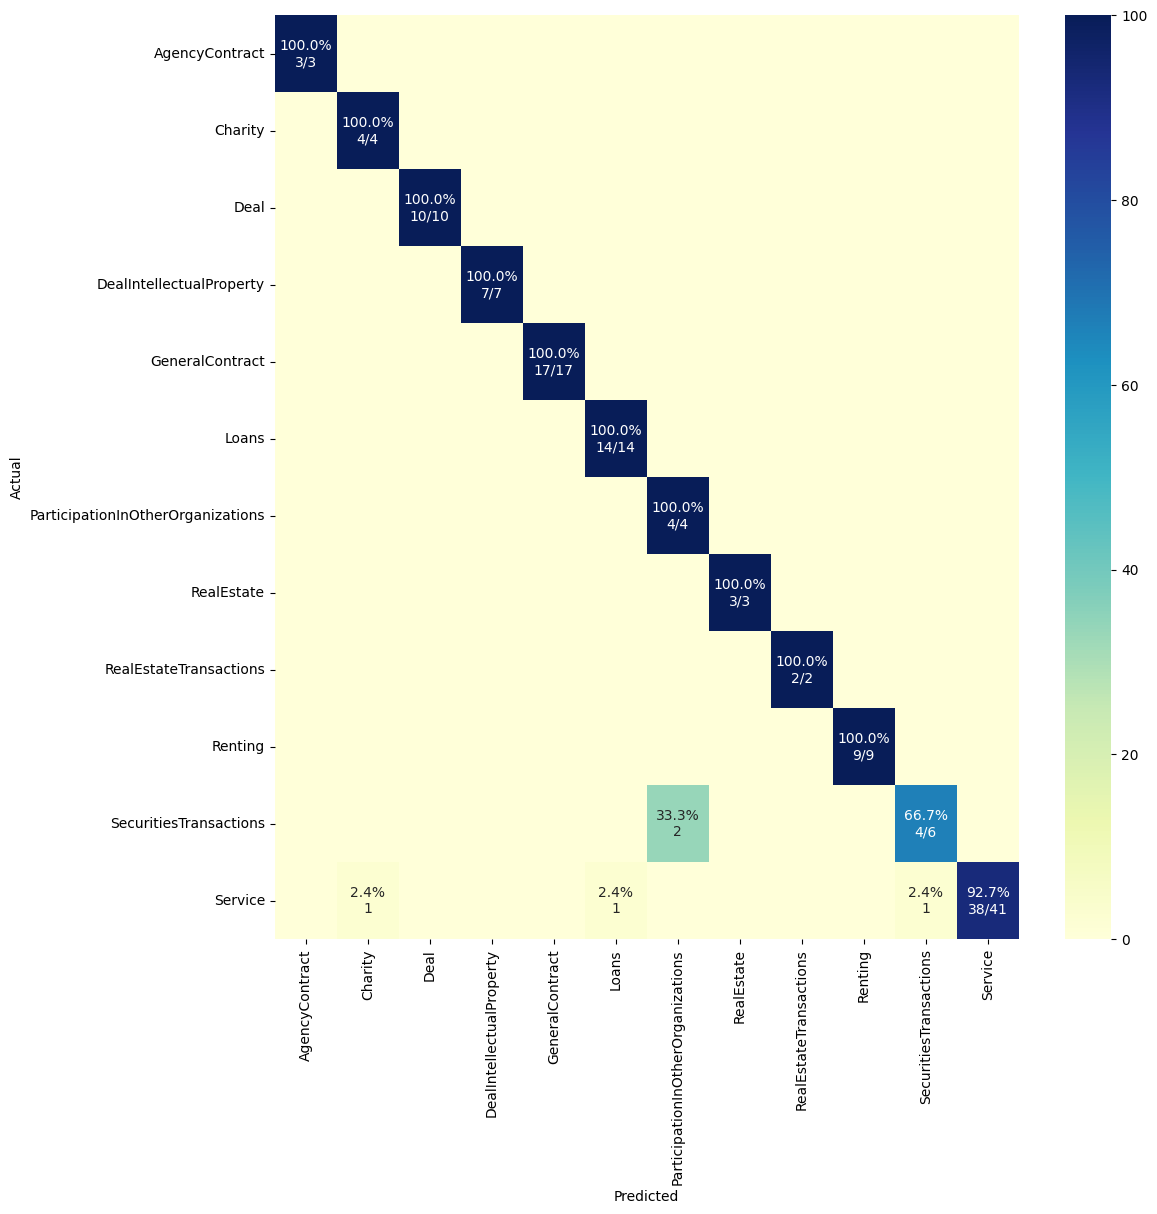

In [49]:


def make_report(umodel, subj_df):
  plot_cm(subj_df.subject_expected.values, subj_df.subject_predicted.values, figsize=(12, 12))
  
  img_path = training_reports_path / f'subjects-confusion-matrix-{umodel.name}.png'
  plt.savefig(img_path, bbox_inches='tight')
  mlflow.log_artifact(img_path)

  report = classification_report(subj_df.subject_expected, subj_df.subject_predicted, digits=3)
  print(umodel.name)
  print(report)

  fn = training_reports_path / f'subjects-classification_report-{umodel.name}.txt'
  with open(fn, "w") as text_file:
    text_file.write(report)
 
  mlflow.log_artifact(fn)


make_report(umodel, subj_df)

In [50]:
if sub_mlflow_run is not None:
    mlflow.end_run()